In [1]:
import numpy
from scipy.constants import c as light_speed
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from matplotlib import rc
import healpy
rcParams['mathtext.default'] = 'regular'

In [11]:
def cross_dipole(theta):
    response = numpy.cos(theta)
    return response


def electric_field_ground_plane(theta, frequency=150e6 , height= 0.3):
    wavelength = light_speed/frequency
    ground_plane_electric_field = numpy.sin(2.*numpy.pi*height/wavelength*numpy.cos(theta))
    return ground_plane_electric_field


def get_array_factor(x,y,z, weights ,theta, phi,  theta_pointing = 0, phi_pointing = 0, frequency=150e6):
    wavelength = light_speed/frequency
    number_dipoles= len(x)
    k_x = (2.*numpy.pi/wavelength)*numpy.sin(theta)*numpy.sin(phi)
    k_y = (2.*numpy.pi/wavelength)*numpy.sin(theta)*numpy.cos(phi)
    k_z = (2.*numpy.pi/wavelength)*numpy.cos(theta)
    
    k_x0 = (2.*numpy.pi/wavelength)*numpy.sin(theta_pointing)*numpy.sin(phi_pointing) 
    k_y0 = (2.*numpy.pi/wavelength)*numpy.sin(theta_pointing)*numpy.cos(phi_pointing)
    k_z0 = (2.*numpy.pi/wavelength)*numpy.cos(theta_pointing)
    array_factor_map = numpy.zeros(theta.shape, dtype=complex)
    for i in range(number_dipoles):
        array_factor_map += weights[i]*numpy.exp(1.j*((k_x - k_x0)*x[i] + (k_y - k_y0)*y[i] + (k_z - k_z0)*z[i]))
    
    
    return array_factor_map/sum(weights)  



def simple_mwa_tile(theta, phi,target_theta=0, target_phi=0,  frequency=150e6, weights=1, dipole_type = 'cross', 
                    theta_width=30/180*numpy.pi):
    dipole_sep = 1.1    # meters
    x_offsets = numpy.array([-1.5,-0.5,0.5,1.5,-1.5,-0.5,0.5,1.5,-1.5,
                             -0.5,0.5,1.5,-1.5,-0.5,0.5,1.5],dtype=numpy.float32)*dipole_sep
    y_offsets = numpy.array([1.5,1.5,1.5,1.5,0.5,0.5,0.5,0.5,-0.5,-0.5,
                             -0.5,-0.5,-1.5,-1.5,-1.5,-1.5],dtype=numpy.float32)*dipole_sep 
    z_offsets = numpy.zeros(x_offsets.shape)
    
    weights += numpy.zeros(x_offsets.shape) 
    
    if dipole_type == 'cross':
        dipole_jones_matrix = cross_dipole(theta)
    elif dipole_type == 'gaussian':
        print(theta_width)
        dipole_jones_matrix = gaussian_response(theta, theta_width)
    else:
        print("Wrong dipole_type: select cross or gaussian")

    ground_plane_field = electric_field_ground_plane(theta, frequency)
    
    array_factor = get_array_factor(x_offsets, y_offsets, z_offsets, weights, theta, phi, target_theta, target_phi,
                                    frequency)
    
    tile_response = numpy.zeros(dipole_jones_matrix.shape, dtype = complex)
    tile_response = array_factor*ground_plane_field*dipole_jones_matrix
    
    return tile_response

In [12]:
def lm_to_theta_phi(ll,mm):
    theta = numpy.arcsin(numpy.sqrt(ll**2. + mm**2.))
    phi = numpy.arctan(mm/ll)
    return theta, phi

In [13]:
def healpy_plotting(tt, pp, tile_response):
    nside =32
    n_pixels = healpy.nside2npix(nside)
    
    indices = healpy.ang2pix(nside, tt.flatten(), pp.flatten())
    healpixmap = numpy.zeros((n_pixels), dtype=complex)

    healpixmap[indices] += tile_response.flatten()

    healpy.orthview(numpy.abs(healpixmap), rot =[0,90,0], half_sky=True, norm='none')
    healpy.graticule()

In [14]:
def powerbox_fft(l,image):
    delta_l = numpy.diff(l)
    dim = numpy.max(l) - numpy.min(l)
    shifted_image = numpy.fft.ifftshift(image)
    ft_beam, grid = powerbox.dft.fft(shifted_image, L=dim, axes=(0, 1))
    norm_ft_beam = ft_beam/delta_l[0]**2.
    return ft_beam, grid

In [30]:
l = numpy.linspace(-100,100, 513)
m = l.copy()


ll, mm = numpy.meshgrid(l, m)
tt, pp = lm_to_theta_phi(ll,mm)

tile_response = simple_mwa_tile(tt, pp, frequency=150e6)


/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arcsin
  
/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arctan
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
#healpy_plotting(tt, pp, tile_response)

In [32]:
import powerbox


In [33]:
#Do some NaN filtering
dipole_sep = 1.1    # meters
x_offsets = numpy.array([-1.5,-0.5,0.5,1.5,-1.5,-0.5,0.5,1.5,-1.5,
                             -0.5,0.5,1.5,-1.5,-0.5,0.5,1.5],dtype=numpy.float32)*dipole_sep
y_offsets = numpy.array([1.5,1.5,1.5,1.5,0.5,0.5,0.5,0.5,-0.5,-0.5,
                             -0.5,-0.5,-1.5,-1.5,-1.5,-1.5],dtype=numpy.float32)*dipole_sep 

antenna_number = 0

dipole_response = cross_dipole(tt)*electric_field_ground_plane(tt)*\
                    numpy.exp(2*numpy.pi*1j/2*(x_offsets[antenna_number]*ll + y_offsets[antenna_number]*mm ))

tile_response[numpy.isnan(tile_response)]=0
dipole_response[numpy.isnan(dipole_response)]=0

(-1, 1)

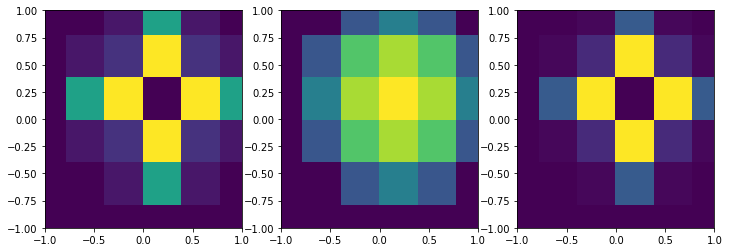

In [34]:
%matplotlib inline
figure = pyplot.figure(figsize=(12,4))
tile_plot =figure.add_subplot(131)
dipole_plot = figure.add_subplot(132)
diptile_plot = figure.add_subplot(133)

tile_plot.pcolor(l,m, numpy.abs(tile_response))
dipole_plot.pcolor(l,m, numpy.abs(dipole_response))
diptile_plot.pcolor(l,m, numpy.abs(dipole_response*tile_response))

tile_plot.set_xlim(-1,1)
tile_plot.set_ylim(-1,1)

dipole_plot.set_xlim(-1,1)
dipole_plot.set_ylim(-1,1)

diptile_plot.set_xlim(-1,1)
diptile_plot.set_ylim(-1,1)

In [35]:
ft_tilebeam, uv_coords = powerbox_fft(l, tile_response)
ft_dipole, uv_coordse = powerbox_fft(l, dipole_response)
ft_diptile, uv_coords = powerbox_fft(l, dipole_response*tile_response)

<IPython.core.display.Javascript object>


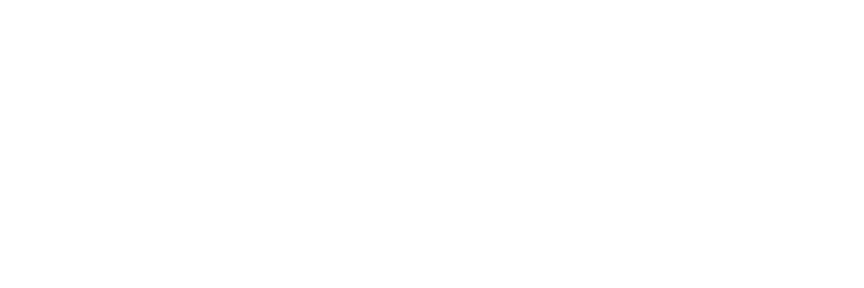

<IPython.core.display.Javascript object>


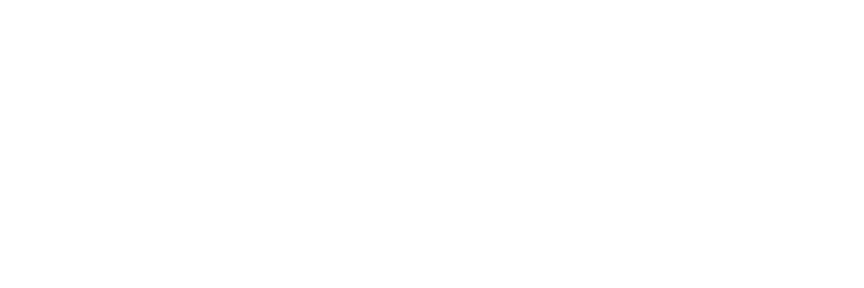

In [37]:
%matplotlib notebook
ft_figure = pyplot.figure(figsize=(12,4))
tile_plot =ft_figure.add_subplot(131)
dipole_plot = ft_figure.add_subplot(132)
diptile_plot = ft_figure.add_subplot(133)

tile_plot.pcolor(uv_coords[0], uv_coords[1], numpy.abs(ft_tilebeam))
dipole_plot.pcolor(uv_coords[0], uv_coords[1], numpy.abs(ft_dipole))
diptile_plot.pcolor(uv_coords[0], uv_coords[1], numpy.abs(ft_diptile))


beam thoughts.

Each dipole is a delta function convolved with FT(dipole_beam)

